In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s4e4/sample_submission.csv
/kaggle/input/playground-series-s4e4/train.csv
/kaggle/input/playground-series-s4e4/test.csv
/kaggle/input/ps-4-e-2-abalone-dataset-from-uci/abalone.names
/kaggle/input/ps-4-e-2-abalone-dataset-from-uci/Index
/kaggle/input/ps-4-e-2-abalone-dataset-from-uci/abalone.data


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
from optuna.samplers import TPESampler
import pickle
from IPython.core.display import HTML
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import StackingRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_log_error

In [3]:
original_train = pd.read_csv('/kaggle/input/ps-4-e-2-abalone-dataset-from-uci/abalone.data', header=None)

train = pd.read_csv('/kaggle/input/playground-series-s4e4/train.csv')
test = pd.read_csv('/kaggle/input/playground-series-s4e4/test.csv')
sample_submission = pd.read_csv('/kaggle/input/playground-series-s4e4/sample_submission.csv')

In [4]:
# Show all properties on display
pd.set_option('display.max_columns', None)

train.head()

,id,Sex,Length,Diameter,Height,Whole weight,Whole weight.1,Whole weight.2,Shell weight,Rings
0,0,F,0.550,0.430,0.150,0.7715,0.3285,0.1465,0.2400,11
1,1,F,0.630,0.490,0.145,1.1300,0.4580,0.2765,0.3200,11
2,2,I,0.160,0.110,0.025,0.0210,0.0055,0.0030,0.0050,6
3,3,M,0.595,0.475,0.150,0.9145,0.3755,0.2055,0.2500,10
4,4,I,0.555,0.425,0.130,0.7820,0.3695,0.1600,0.1975,9


In [5]:
test.head()

,id,Sex,Length,Diameter,Height,Whole weight,Whole weight.1,Whole weight.2,Shell weight
0,90615,M,0.645,0.475,0.155,1.2380,0.6185,0.3125,0.3005
1,90616,M,0.580,0.460,0.160,0.9830,0.4785,0.2195,0.2750
2,90617,M,0.560,0.420,0.140,0.8395,0.3525,0.1845,0.2405
3,90618,M,0.570,0.490,0.145,0.8740,0.3525,0.1865,0.2350
4,90619,I,0.415,0.325,0.110,0.3580,0.1575,0.0670,0.1050


In [6]:
print(original_train.shape)
original_train.columns.tolist()

(4177, 9)


[0, 1, 2, 3, 4, 5, 6, 7, 8]

In [7]:
# Save original dataset into .csv
original_train.columns = train.columns[1:]
original_train.to_csv('🌊🐚⛵🍤 PS4 E4 original abalone dataset from UCI.csv', index=False)
original_train.tail()

,Sex,Length,Diameter,Height,Whole weight,Whole weight.1,Whole weight.2,Shell weight,Rings
4172,F,0.565,0.450,0.165,0.8870,0.3700,0.2390,0.2490,11
4173,M,0.590,0.440,0.135,0.9660,0.4390,0.2145,0.2605,10
4174,M,0.600,0.475,0.205,1.1760,0.5255,0.2875,0.3080,9
4175,F,0.625,0.485,0.150,1.0945,0.5310,0.2610,0.2960,10
4176,M,0.710,0.555,0.195,1.9485,0.9455,0.3765,0.4950,12


In [8]:
print(train.shape)
train.columns.tolist()

(90615, 10)


['id',
 'Sex',
 'Length',
 'Diameter',
 'Height',
 'Whole weight',
 'Whole weight.1',
 'Whole weight.2',
 'Shell weight',
 'Rings']

In [9]:
submission_id = test.id

train.drop(columns='id', axis=1, inplace=True)
test.drop(columns='id', axis=1, inplace=True)

In [10]:
train = pd.concat(objs=[train, original_train])
train.shape

(94792, 9)

In [11]:
train_duplicates_number = train[train.duplicated()]
test_duplicates_number = test[test.duplicated()]
                             
print(len(train_duplicates_number))
print(len(test_duplicates_number))

0
0


#### There are no any duplicats in data but if they would be presented use code below

In [12]:
train = train.drop_duplicates()

# Check whether all duplicates were removed
train_duplicates = train[train.duplicated()]
print(len(train_duplicates))

0


In [13]:
print(f'Train data: {train.shape}')
print(f'Test data: {test.shape}\n')

train_data_percentage = np.round(train.shape[0] / (train.shape[0] + test.shape[0]), 4)
print(f'Train data consists of {train_data_percentage * 100}% of all observations')
print(f'Test data consists of {(1 - train_data_percentage) * 100}% of all observations')

Train data: (94792, 9)
Test data: (60411, 8)

Train data consists of 61.08% of all observations
Test data consists of 38.92% of all observations


In [14]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
Length,94792.0,0.517402,0.118308,0.0750,0.4450,0.5450,0.6000,0.8150
Diameter,94792.0,0.401952,0.098088,0.0550,0.3450,0.4250,0.4700,0.6500
Height,94792.0,0.135643,0.038193,0.0000,0.1100,0.1400,0.1600,1.1300
Whole weight,94792.0,0.790785,0.459231,0.0020,0.4195,0.7995,1.0725,2.8255
Whole weight.1,94792.0,0.341597,0.205267,0.0010,0.1775,0.3300,0.4645,1.4880
Whole weight.2,94792.0,0.169914,0.101334,0.0005,0.0865,0.1660,0.2330,0.7600
Shell weight,94792.0,0.226468,0.130639,0.0015,0.1200,0.2250,0.3050,1.0050
Rings,94792.0,9.707233,3.178704,1.0000,8.0000,9.0000,11.0000,29.0000


In [15]:
print('TRAIN data\n')
print(f'{train.isna().sum()}\n\n\n')

print('TEST data\n')
print(test.isna().sum())

TRAIN data

Sex               0
Length            0
Diameter          0
Height            0
Whole weight      0
Whole weight.1    0
Whole weight.2    0
Shell weight      0
Rings             0
dtype: int64



TEST data

Sex               0
Length            0
Diameter          0
Height            0
Whole weight      0
Whole weight.1    0
Whole weight.2    0
Shell weight      0
dtype: int64


#### There is no any gaps in the data

In [16]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 94792 entries, 0 to 4176
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Sex             94792 non-null  object 
 1   Length          94792 non-null  float64
 2   Diameter        94792 non-null  float64
 3   Height          94792 non-null  float64
 4   Whole weight    94792 non-null  float64
 5   Whole weight.1  94792 non-null  float64
 6   Whole weight.2  94792 non-null  float64
 7   Shell weight    94792 non-null  float64
 8   Rings           94792 non-null  int64  
dtypes: float64(7), int64(1), object(1)
memory usage: 7.2+ MB


#### Sex feature is object, so we have to convert in into numeric

In [17]:
train = train.drop_duplicates()

# Check whether all duplicates were removed
duplicates = train[train.duplicated()]
len(duplicates)

0

In [18]:
X = pd.get_dummies(train, drop_first=True, dtype=int)
test = pd.get_dummies(test, drop_first=True, dtype=int)

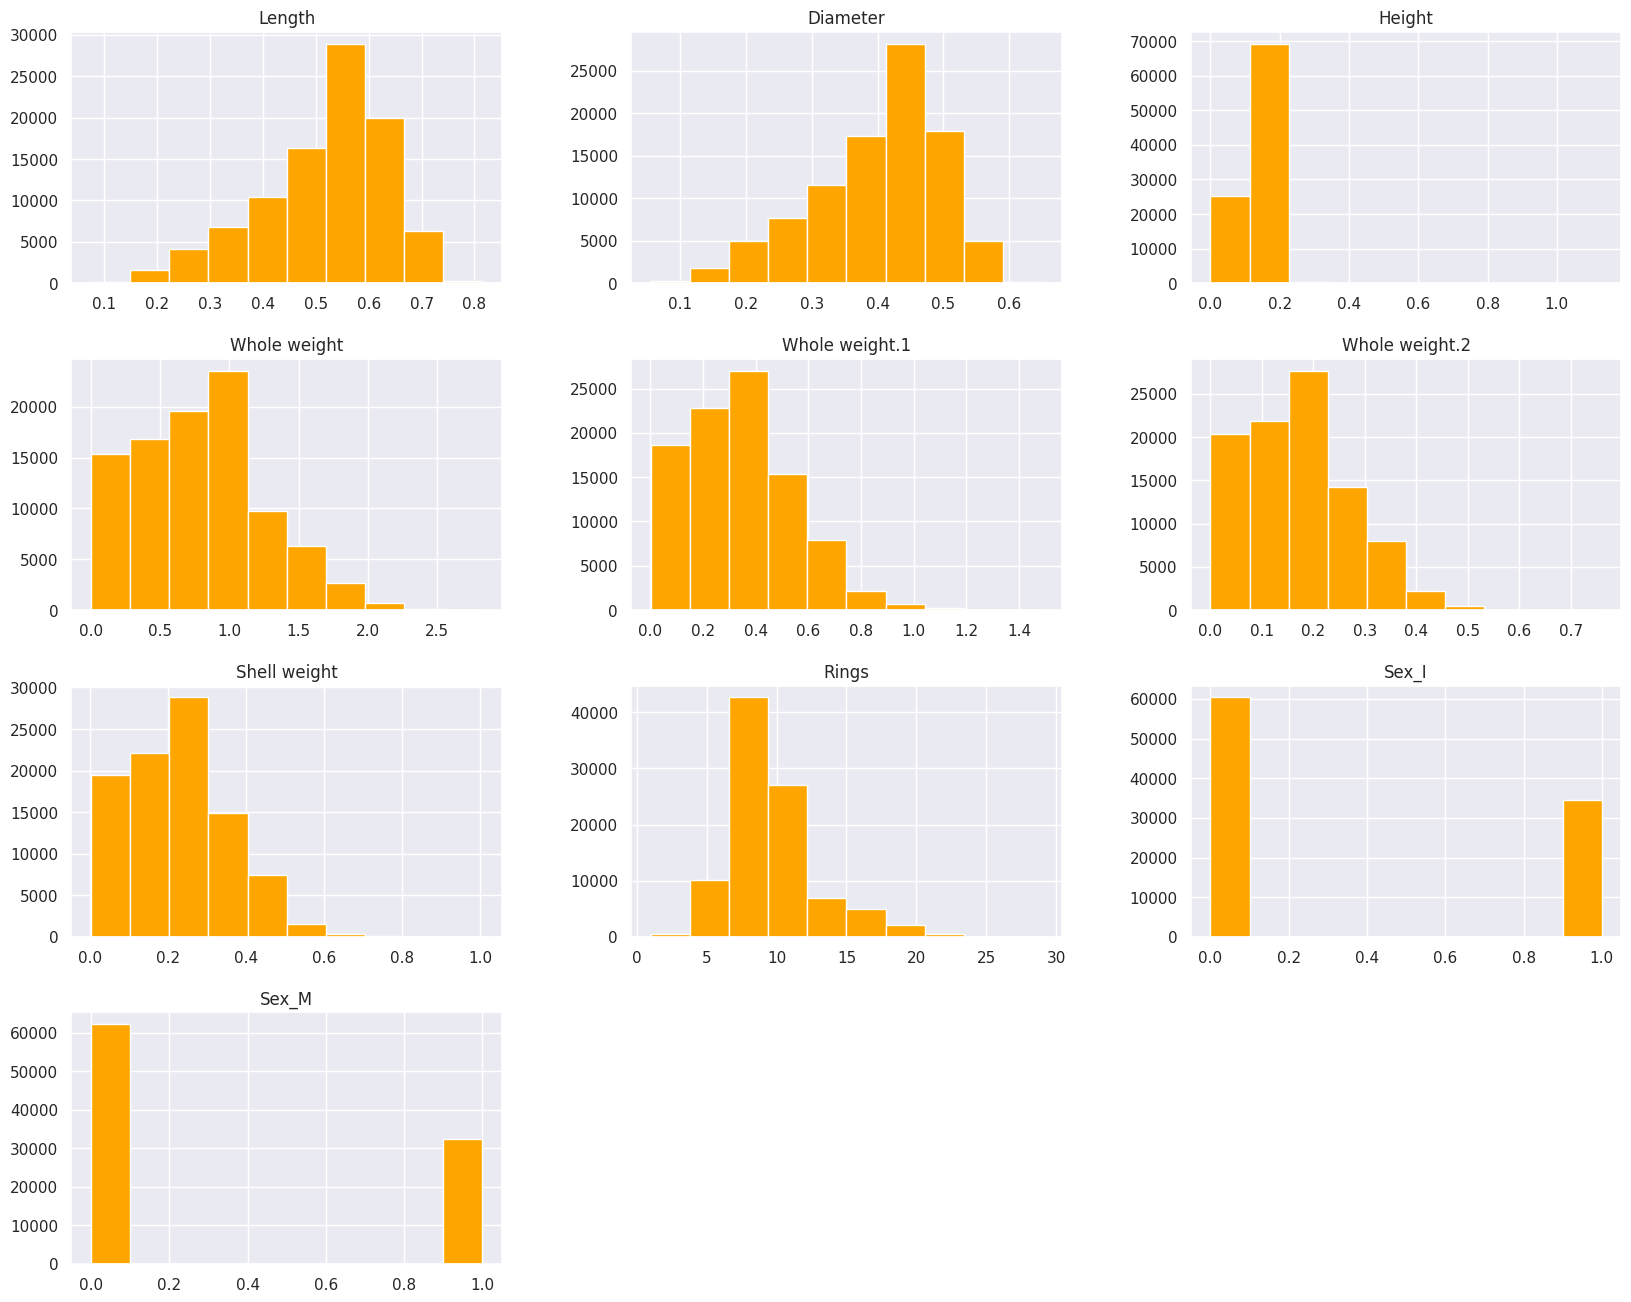

In [19]:
sns.set(rc={'figure.figsize': (20, 16)})
X.hist(color='orange');

In [20]:
print(f'{train.Rings.value_counts()}\n\n')
print(train.Rings.value_counts() / train.shape[0])

Rings
9     18154
8     15067
10    13098
7      9399
11     8894
6      5670
12     4986
13     4277
5      2977
14     2633
15     2175
16     1506
4      1459
17     1233
18      890
19      671
20      533
3       401
21      269
23      189
22      114
27       43
24       31
2        30
1        26
29       25
25       23
26       19
Name: count, dtype: int64


Rings
9     0.191514
8     0.158948
10    0.138176
7     0.099154
11    0.093826
6     0.059815
12    0.052599
13    0.045120
5     0.031406
14    0.027777
15    0.022945
16    0.015887
4     0.015392
17    0.013007
18    0.009389
19    0.007079
20    0.005623
3     0.004230
21    0.002838
23    0.001994
22    0.001203
27    0.000454
24    0.000327
2     0.000316
1     0.000274
29    0.000264
25    0.000243
26    0.000200
Name: count, dtype: float64


In [21]:
# Split the train data into X and y
X = X.drop(['Rings'], axis=1)
y = train.Rings

# for column in X.columns.tolist():
#     X[column] = X[column].apply(lambda x: (x - X[column].min()) / (X[column].max() - X[column].min()))

# # Transform test data
# for column in test.columns.tolist():
#     test[column] = test[column].apply(lambda x: (x - test[column].min()) / (test[column].max() - test[column].min()))
    
# X.hist(color='LightSeaGreen');

CPU times: user 51.8 s, sys: 469 ms, total: 52.3 s
Wall time: 52.3 s


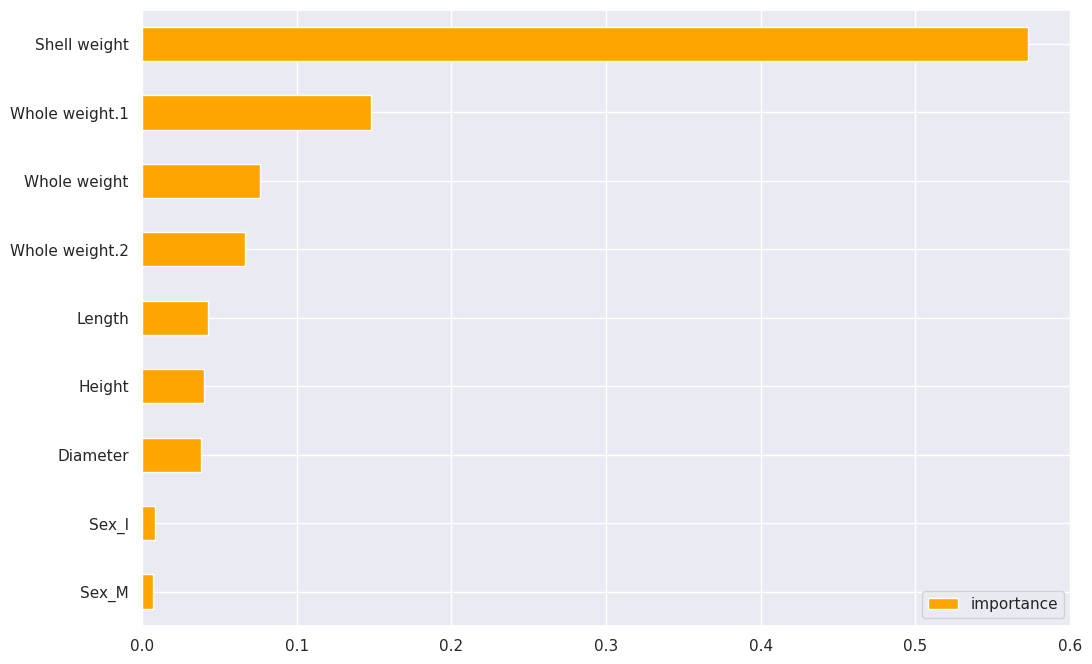

In [22]:
%%time
# I figured out best hyperparameters previously
best_forest = RandomForestRegressor(
    random_state=27,
)
    
best_forest.fit(X, y)
importance = best_forest.feature_importances_

feature_importance = pd.DataFrame(data=importance, index=X.columns, columns=['importance']) \
    .sort_values(ascending=True, by='importance')

feature_importance.plot(kind='barh', figsize=(12, 8), color='orange');

In [23]:
X.columns

Index(['Length', 'Diameter', 'Height', 'Whole weight', 'Whole weight.1',
       'Whole weight.2', 'Shell weight', 'Sex_I', 'Sex_M'],
      dtype='object')

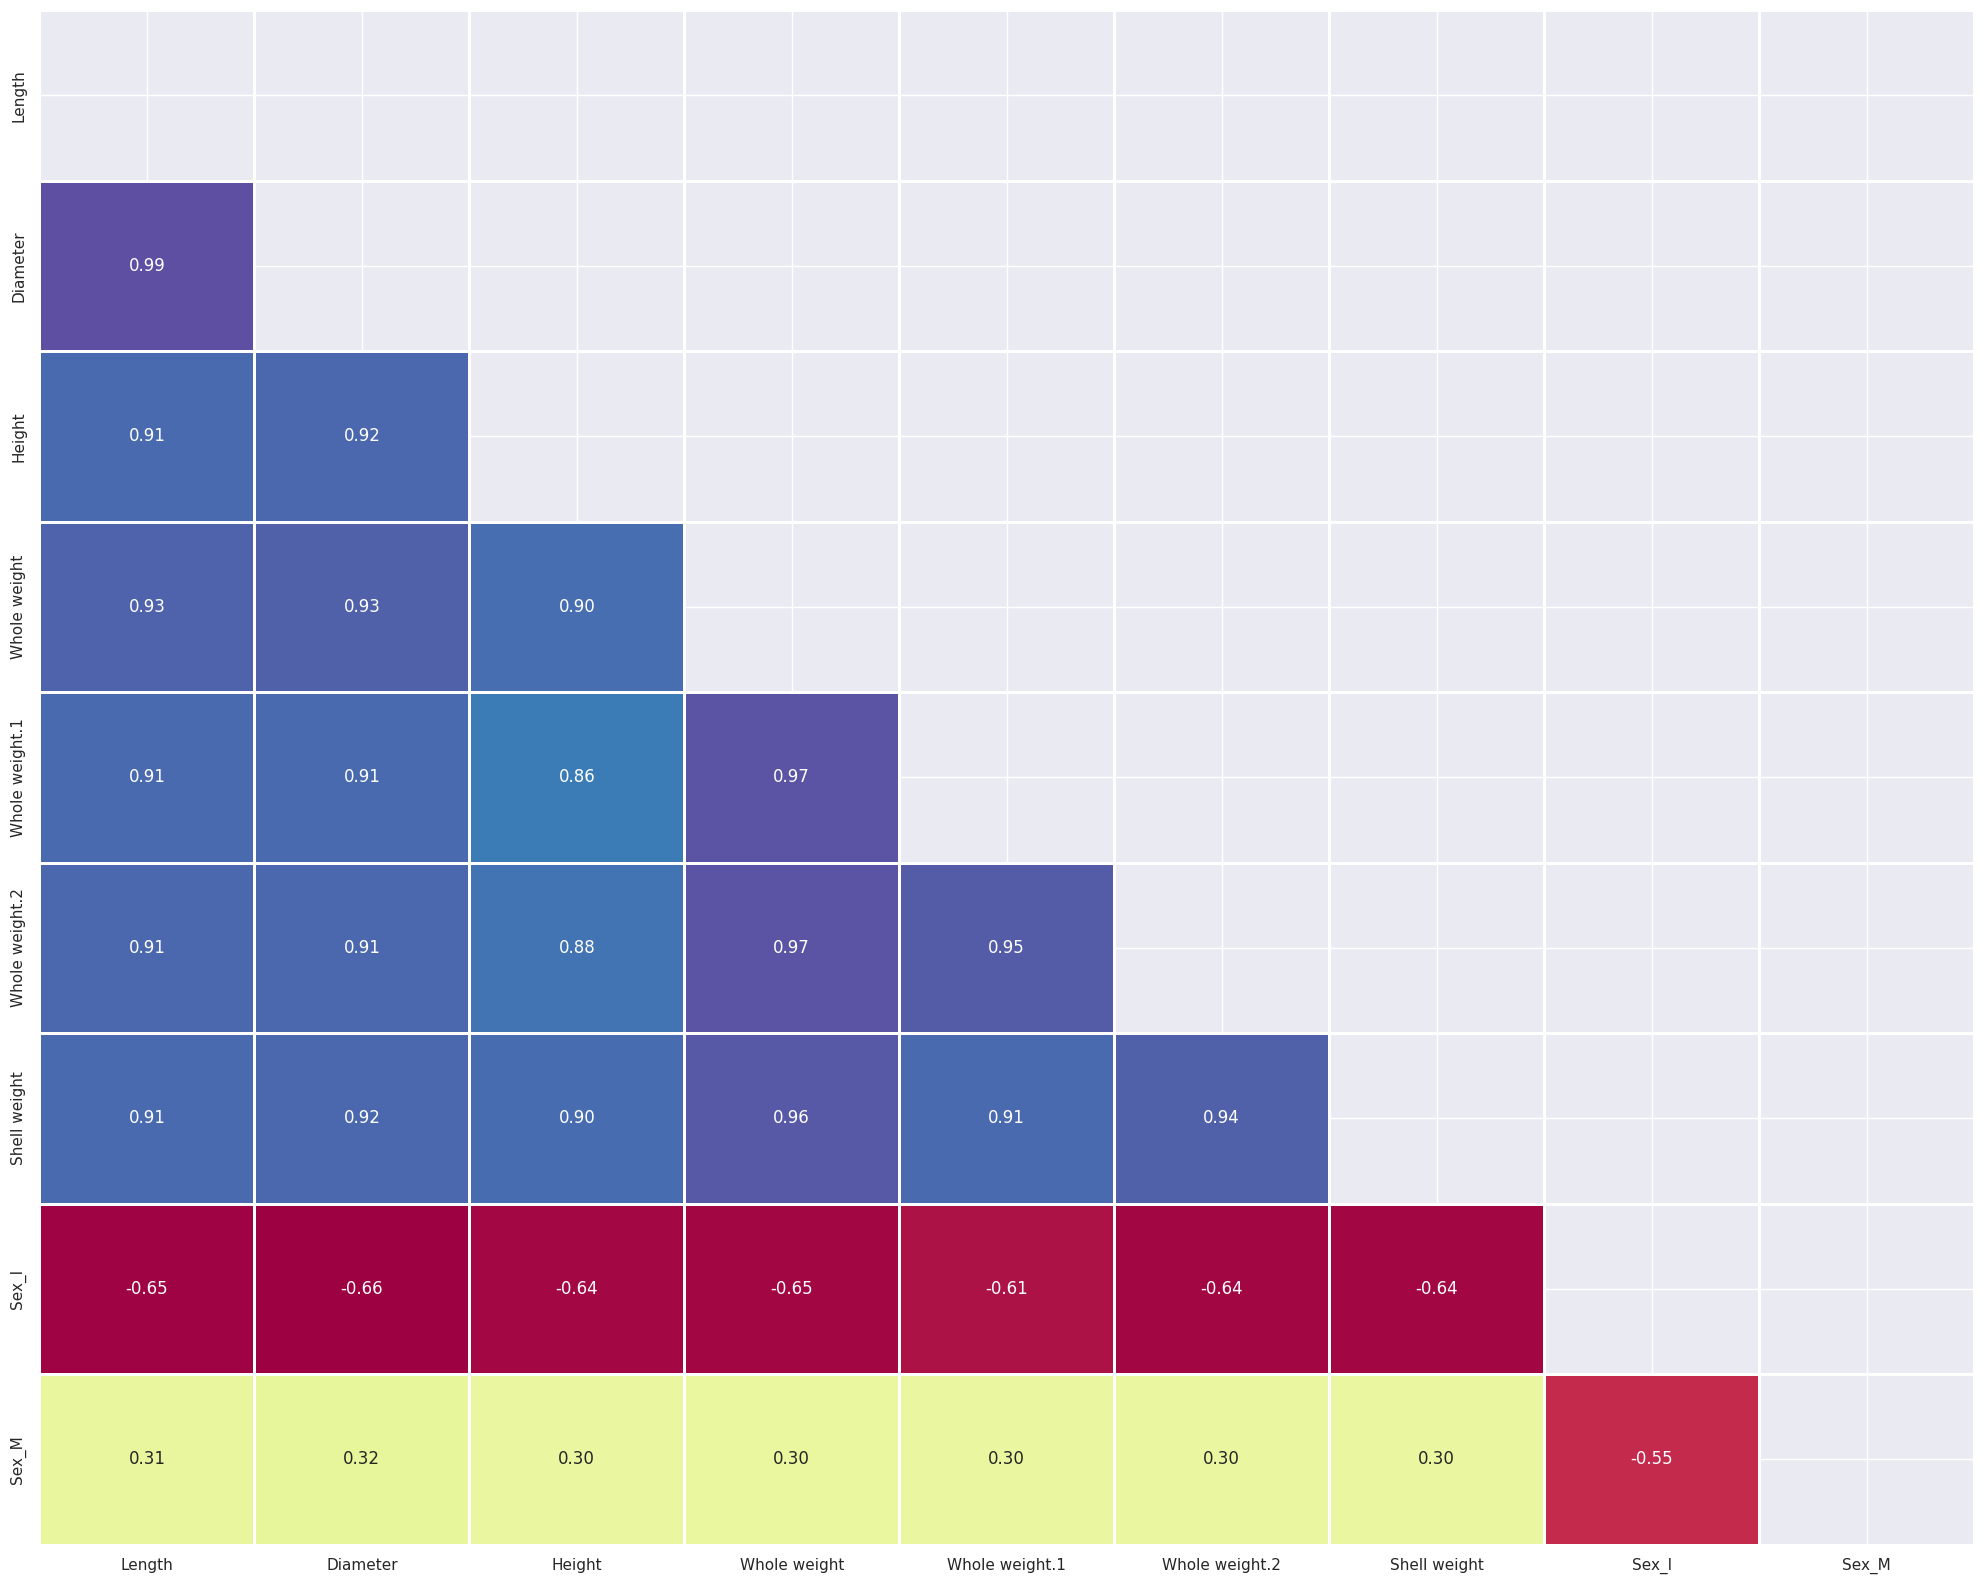

In [24]:
# Training dataset
numeric_columns_train = X.select_dtypes(include=np.number)
corr_train = numeric_columns_train.corr(method='pearson')
mask_train = np.triu(np.ones_like(corr_train))
sns.heatmap(corr_train, annot=True, fmt='.2f', mask=mask_train, cmap='Spectral', cbar=None, linewidth=2)
plt.tight_layout()
plt.show()

#### Let's drop highly correlated features and look on the metric

In [25]:
X = X.drop(['Diameter', 'Whole weight.2', 'Whole weight'], axis=1)
test = test.drop(['Diameter', 'Whole weight.2', 'Whole weight'], axis=1)

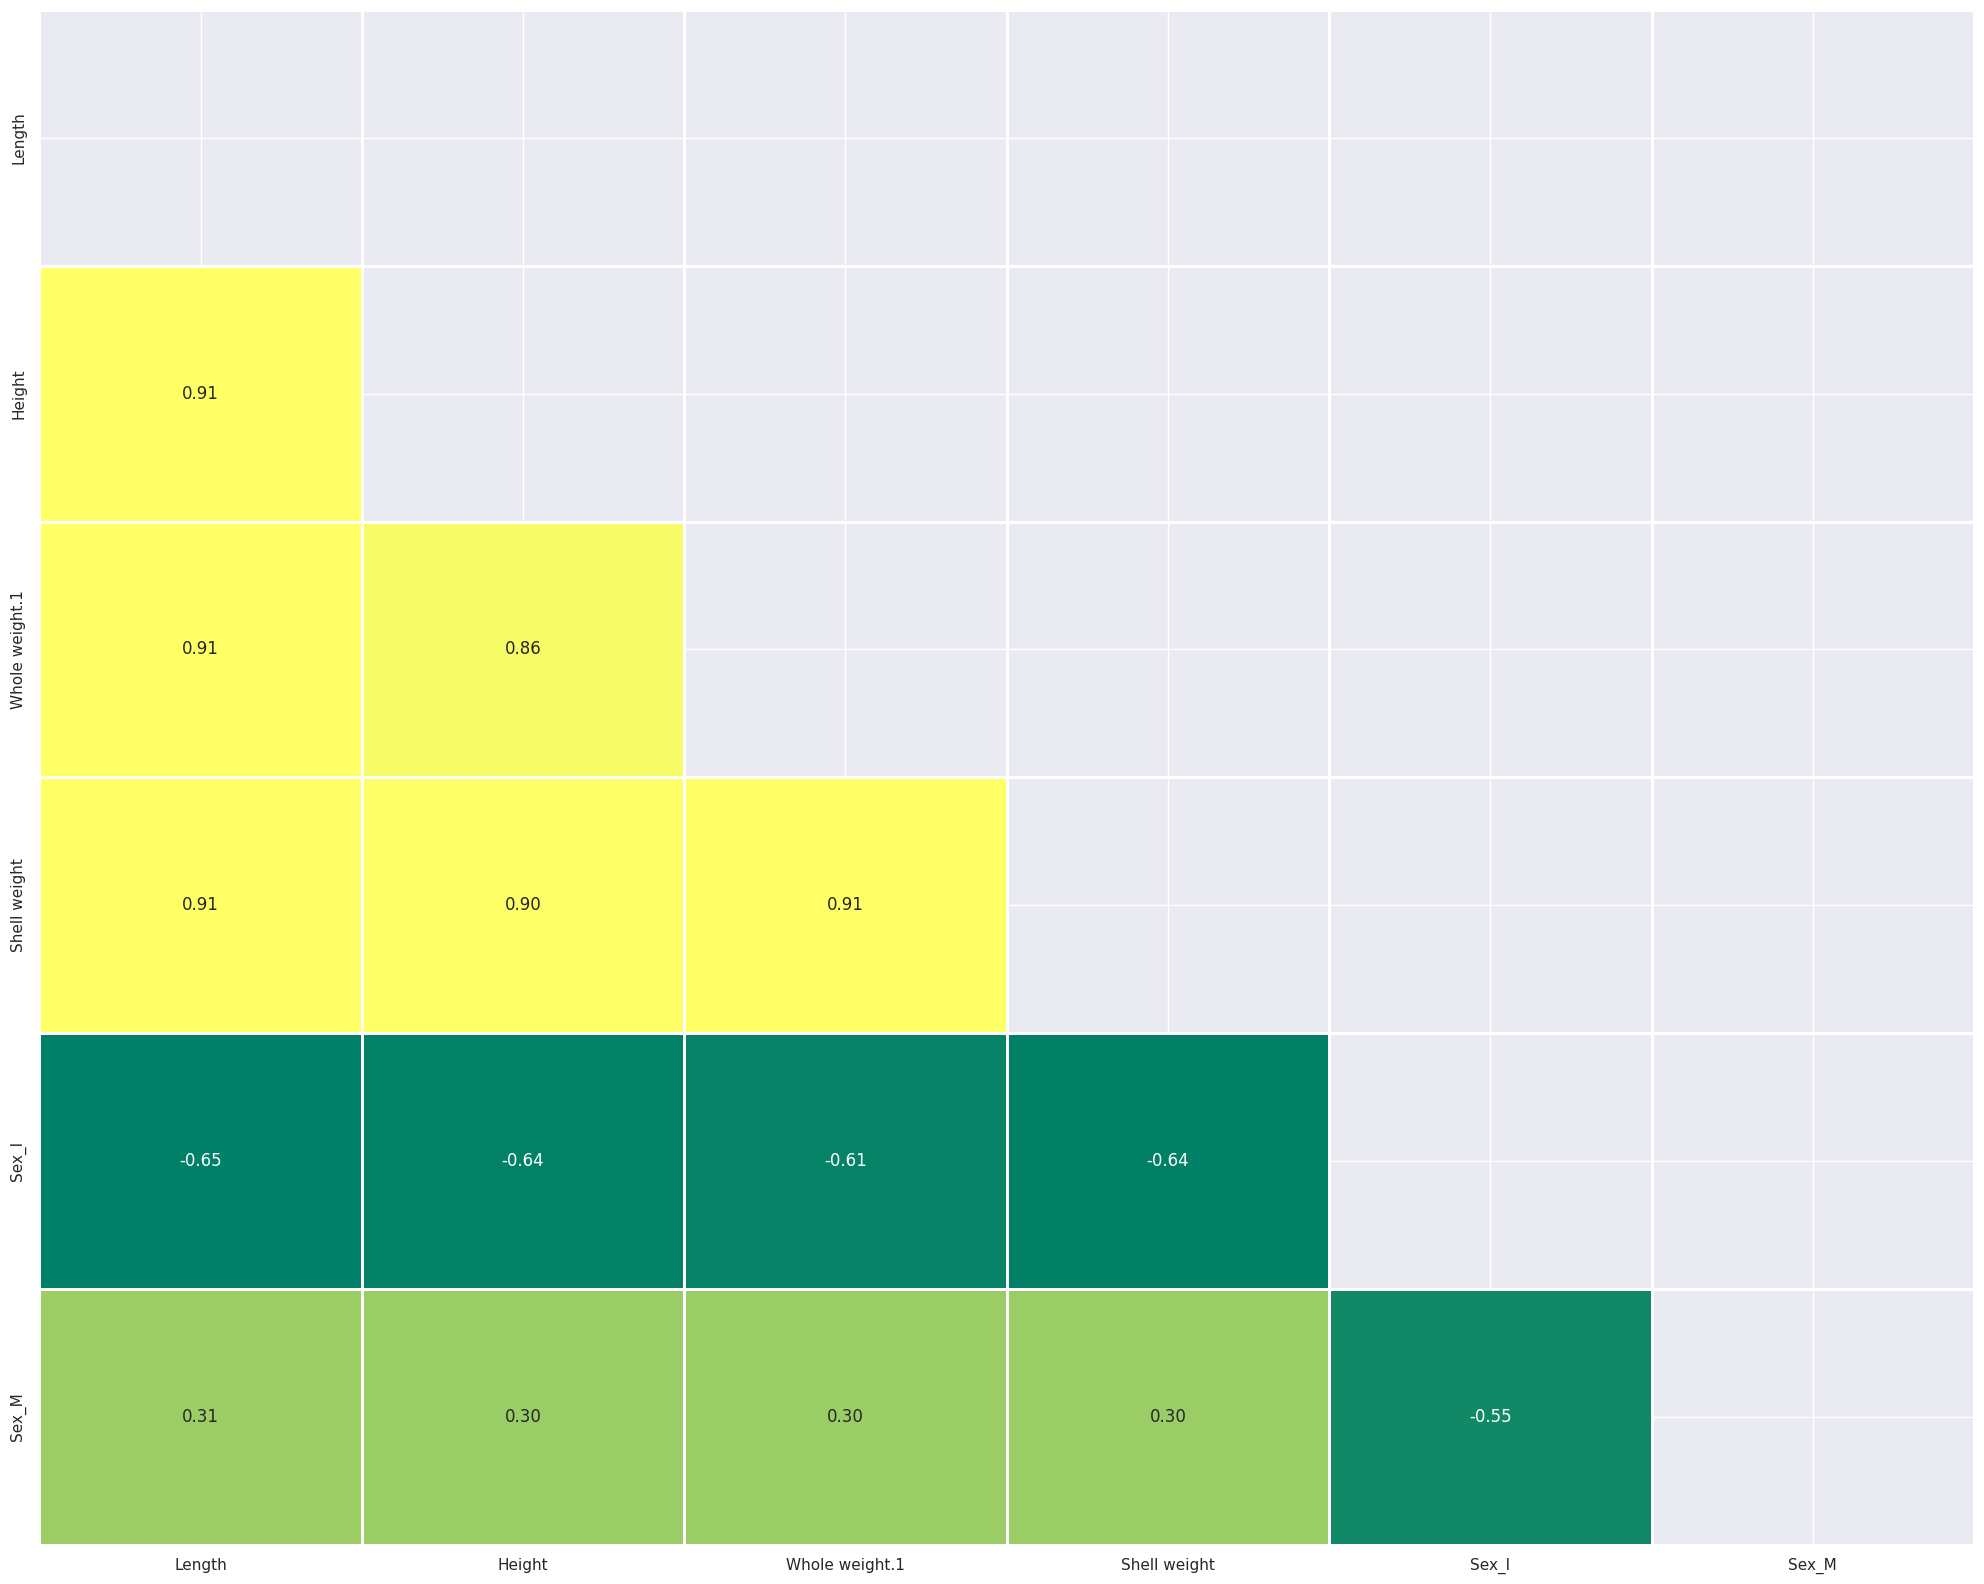

In [26]:
# Training dataset
numeric_columns_train = X.select_dtypes(include=np.number)
corr_train = numeric_columns_train.corr(method='pearson')
mask_train = np.triu(np.ones_like(corr_train))
sns.heatmap(corr_train, annot=True, fmt='.2f', mask=mask_train, cmap='summer', cbar=None, linewidth=2)
plt.tight_layout()
plt.show()

In [27]:
# Split data into train and val
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=27)

In [28]:
# %%time
# def objective(trial):
#     model = RandomForestRegressor(
#         n_estimators=trial.suggest_int("n_estimators", 100, 1000),
# #         criterion=trial.suggest_categorical("criterion", ['poisson', 'absolute_error', 'friedman_mse', 'squared_error']),
#         min_samples_leaf=trial.suggest_int("min_samples_leaf", 1, 100),
#         max_depth=trial.suggest_int("max_depth", 1, 100),
#         min_samples_split=trial.suggest_int("min_samples_split", 2, 100),
#         random_state=27
#     )
#     model.fit(X_train, y_train)
#     y_pred = model.predict(X_test)
#     return np.sqrt(mean_squared_log_error(y_test, y_pred))


# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=27)

# optuna.logging.set_verbosity(optuna.logging.WARNING)

# sampler = TPESampler(seed=27)
# study = optuna.create_study(study_name="random_forest", direction="maximize", sampler=sampler)
# study.optimize(objective, n_trials=5)

# print("Number of finished trials: ", len(study.trials))
# print("Best trial:")
# trial = study.best_trial
# print("  Value: ", trial.value)
# print("  Params: ")
# for key, value in trial.params.items():
#     print(f"    {key}: {value}")
# print()

"""
Number of finished trials:  5
Best trial:
  Value:  0.15237508927103727
  Params: 
    n_estimators: 445
    min_samples_leaf: 98
    max_depth: 90
    min_samples_split: 22

CPU times: user 11min 43s, sys: 171 ms, total: 11min 44s
Wall time: 11min 44s
"""

'\nNumber of finished trials:  5\nBest trial:\n  Value:  0.15237508927103727\n  Params: \n    n_estimators: 445\n    min_samples_leaf: 98\n    max_depth: 90\n    min_samples_split: 22\n\nCPU times: user 11min 43s, sys: 171 ms, total: 11min 44s\nWall time: 11min 44s\n'

In [29]:
# %%time
# def objective(trial):
#     model = XGBRegressor(
#         max_depth=trial.suggest_int('max_depth', 1, 100),
#         learning_rate=trial.suggest_float('learning_rate', 0.01, 1.0, log=True),
#         n_estimators=trial.suggest_int('n_estimators', 50, 1000),
#         min_child_weight=trial.suggest_int('min_child_weight', 1, 10),
#         gamma=trial.suggest_float('gamma', 1e-8, 1.0, log=True),
#         subsample=trial.suggest_float('subsample', 0.01, 1.0, log=True),
#         colsample_bytree=trial.suggest_float('colsample_bytree', 0.01, 1.0, log=True),
#         reg_alpha=trial.suggest_float('reg_alpha', 1e-8, 1.0, log=True),
#         reg_lambda=trial.suggest_float('reg_lambda', 1e-8, 1.0, log=True),
#         use_label_encoder=False,
#         random_state=27
#     )
#     model.fit(X_train, y_train)
#     y_pred = model.predict(X_test)
#     try:
#         return np.sqrt(mean_squared_log_error(y_test, y_pred))
#     except Exception as e:
#         print(e)


# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=27)

# optuna.logging.set_verbosity(optuna.logging.WARNING)

# sampler = TPESampler(seed=27)
# study = optuna.create_study(study_name="xgb", direction="maximize", sampler=sampler)
# study.optimize(objective, n_trials=1)

# print("Number of finished trials: ", len(study.trials))
# print("Best trial:")
# trial = study.best_trial
# print("  Value: ", trial.value)
# print("  Params: ")
# for key, value in trial.params.items():
#     print(f"    {key}: {value}")
# print()

"""
Number of finished trials:  1
Best trial:
  Value:  0.1775845058982026
  Params: 
    max_depth: 43
    learning_rate: 0.42576257222865277
    n_estimators: 749
    min_child_weight: 9
    gamma: 1.1669337024772915e-05
    subsample: 0.9097315662154742
    colsample_bytree: 0.6114890625963008
    reg_alpha: 4.761254082318455e-07
    reg_lambda: 0.008602430632882225

CPU times: user 24.5 s, sys: 667 ms, total: 25.2 s
Wall time: 25.2 s
"""

'\nNumber of finished trials:  1\nBest trial:\n  Value:  0.1775845058982026\n  Params: \n    max_depth: 43\n    learning_rate: 0.42576257222865277\n    n_estimators: 749\n    min_child_weight: 9\n    gamma: 1.1669337024772915e-05\n    subsample: 0.9097315662154742\n    colsample_bytree: 0.6114890625963008\n    reg_alpha: 4.761254082318455e-07\n    reg_lambda: 0.008602430632882225\n\nCPU times: user 24.5 s, sys: 667 ms, total: 25.2 s\nWall time: 25.2 s\n'

In [30]:
# # Searching for best parameters of XGBoost
# from sklearn.model_selection import RandomizedSearchCV

# xgb_regressor = XGBRegressor(random_state=27)

# xgb_parameters = {
#     'n_estimators': range(5, 1001, 10),
#     'learning_rate': [0.001, 0.05, 0.01],
#     'max_depth': range(2, 100, 4),
# }

# xgb_random_search = RandomizedSearchCV(estimator=xgb_regressor, param_distributions=xgb_parameters, n_iter=5, n_jobs=-1, cv=5, verbose=4, random_state=27)
# xgb_random_search.fit(X_val, y_val)
# print(f'Best params: {xgb_random_search.best_params_}')

"""
Best params: {'n_estimators': 395, 'max_depth': 6, 'learning_rate': 0.01}
"""

"\nBest params: {'n_estimators': 395, 'max_depth': 6, 'learning_rate': 0.01}\n"

#### I found that XGBoost in this competition can't work with negative targets when it is looking for model that fitting with metrics

In [31]:
# %%time
# def objective(trial):
#     model = CatBoostRegressor(
#         iterations=trial.suggest_int("iterations", 100, 1000),
#         learning_rate=trial.suggest_float("learning_rate", 1e-3, 1e-1, log=True),
#         colsample_bylevel=trial.suggest_float("colsample_bylevel", 0.05, 1.0),
#         min_data_in_leaf=trial.suggest_int("min_data_in_leaf", 1, 100),
#         depth=trial.suggest_int("depth", 4, 16),
#         l2_leaf_reg=trial.suggest_float("l2_leaf_reg", 1e-8, 100.0, log=True),
#         verbose=False,
#         random_state=27
#     )
#     model.fit(X_train, y_train)
#     y_pred = model.predict(X_test)
#     return np.sqrt(mean_squared_log_error(y_test, y_pred))


# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=27)

# optuna.logging.set_verbosity(optuna.logging.WARNING)

# sampler = TPESampler(seed=27)
# study = optuna.create_study(study_name="catboost", direction="maximize", sampler=sampler)
# study.optimize(objective, n_trials=20)

# print("Number of finished trials: ", len(study.trials))
# print("Best trial:")
# trial = study.best_trial
# print("  Value: ", trial.value)
# print("  Params: ")

# for key, value in trial.params.items():
#     print(f"    {key}: {value}")
# print()

"""
Number of finished trials:  20
Best trial:
  Value:  0.27250015755480833
  Params: 
    iterations: 101
    learning_rate: 0.0010172906333606835
    colsample_bylevel: 0.4796381789116622
    min_data_in_leaf: 42
    depth: 13
    l2_leaf_reg: 2.895211427077531e-08

CPU times: user 18min 10s, sys: 9min 21s, total: 27min 31s
Wall time: 13min 5s
"""

'\nNumber of finished trials:  20\nBest trial:\n  Value:  0.27250015755480833\n  Params: \n    iterations: 101\n    learning_rate: 0.0010172906333606835\n    colsample_bylevel: 0.4796381789116622\n    min_data_in_leaf: 42\n    depth: 13\n    l2_leaf_reg: 2.895211427077531e-08\n\nCPU times: user 18min 10s, sys: 9min 21s, total: 27min 31s\nWall time: 13min 5s\n'

In [32]:
# %%time
# def objective(trial):
#     model = LGBMRegressor(
#         n_estimators=trial.suggest_int("n_estimators", 100, 1000),
#         max_depth=trial.suggest_int("max_depth", 1, 100),
#         learning_rate=trial.suggest_float("learning_rate", 1e-3, 1e-1, log=True),
#         verbosity=-1,
#         boosting_type=trial.suggest_categorical('boosting_type', ['gbdt', 'dart']),
#         num_leaves=trial.suggest_int('num_leaves', 2, 256),
#         min_child_samples=trial.suggest_int('min_child_samples', 5, 100),
#         random_state=27
#     )
#     model.fit(X_train, y_train)
#     y_pred = model.predict(X_test)
#     return np.sqrt(mean_squared_log_error(y_test, y_pred))


# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=27)

# optuna.logging.set_verbosity(optuna.logging.WARNING)

# sampler = TPESampler(seed=27)
# study = optuna.create_study(study_name="lgbm", direction="maximize", sampler=sampler)
# study.optimize(objective, n_trials=10)

# print("Number of finished trials: ", len(study.trials))
# print("Best trial:")
# trial = study.best_trial
# print("  Value: ", trial.value)
# print("  Params: ")
# for key, value in trial.params.items():
#     print(f"    {key}: {value}")
# print()

"""
Number of finished trials:  10
Best trial:
  Value:  0.793442492293447
  Params: 
    n_estimators: 374
    max_depth: 79
    learning_rate: 0.002117446099339252
    boosting_type: dart
    num_leaves: 48
    min_child_samples: 62

CPU times: user 12min 4s, sys: 269 ms, total: 12min 4s
Wall time: 12min 5s
"""

'\nNumber of finished trials:  10\nBest trial:\n  Value:  0.793442492293447\n  Params: \n    n_estimators: 374\n    max_depth: 79\n    learning_rate: 0.002117446099339252\n    boosting_type: dart\n    num_leaves: 48\n    min_child_samples: 62\n\nCPU times: user 12min 4s, sys: 269 ms, total: 12min 4s\nWall time: 12min 5s\n'

In [33]:
base_models = [
    ('XGBoost', XGBRegressor(
        random_state=27
    )),
    ('LightGBM', LGBMRegressor(
        random_state=27
    )),
    ('Catboost', CatBoostRegressor(
    random_state=27
    )),
    ('RandomForest', RandomForestRegressor(
        random_state=27
    ))
]

In [34]:
meta_model = CatBoostRegressor(
    iterations=101,
    learning_rate=0.0010172906333606835,
    colsample_bylevel=0.4796381789116622,
    min_data_in_leaf=42,
    depth=13,
    l2_leaf_reg=2.895211427077531e-08,
    random_state=27,
)

In [35]:
%%time
stacking_model = StackingRegressor(estimators=base_models, final_estimator=meta_model)
stacking_model.fit(X, y)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005455 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 713
[LightGBM] [Info] Number of data points in the train set: 94792, number of used features: 6
[LightGBM] [Info] Start training from score 9.707233
Learning rate set to 0.084045
0:	learn: 3.0455993	total: 70.1ms	remaining: 1m 10s
1:	learn: 2.9266166	total: 82ms	remaining: 40.9s
2:	learn: 2.8231384	total: 92.9ms	remaining: 30.9s
3:	learn: 2.7277605	total: 104ms	remaining: 25.9s
4:	learn: 2.6430010	total: 116ms	remaining: 23s
5:	learn: 2.5666807	total: 127ms	remaining: 21s
6:	learn: 2.5004098	total: 137ms	remaining: 19.5s
7:	learn: 2.4419693	total: 148ms	remaining: 18.3s
8:	learn: 2.3901300	total: 158ms	remaining: 17.4s
9:	learn: 2.3453274	total: 168ms	remai

StackingRegressor(estimators=[('XGBoost',
                               XGBRegressor(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learnin...
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=None, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=27, ...)),
                              ('LightGBM', LGBMRegressor(random_state=27)),
                              ('Catboost',
                               <catboost.core.CatBoostRegressor object at 0x7d4bd414d180>),
                              ('RandomForest',
                               RandomForestRegressor(random_state=27))],
                  final_estimator=<catboost.core.CatBoostRegressor object at 0x7d4bd414e3b0>)

In [36]:
y_pred_val = stacking_model.predict(X_val)

rmsle_val = np.sqrt(mean_squared_log_error(y_val, y_pred_val))
print(f"Validation Root mean squared logarithmic error regression loss: {rmsle_val:.8f}")

Validation Root mean squared logarithmic error regression loss: 0.27225696


In [37]:
y_pred_test = stacking_model.predict(test)
y_pred_test[:10]

array([9.6684373 , 9.69360626, 9.71916469, 9.78979403, 9.52623251,
       9.66905637, 9.84867737, 9.4147968 , 9.56487964, 9.89387729])

![](https://en.australia51.com/Attach/Download/EA3D1916-8F57-1147-653F-329276FBB95A/0656DE71-5A1F-235F-E504-F21533E82969.jpg)

In [38]:
submission = pd.DataFrame({
    'id': sample_submission.id,
    'Rings': y_pred_test
})

submission.to_csv('submission.csv', index=False)
submission.head(10)

,id,Rings
0,90615,9.668437
1,90616,9.693606
2,90617,9.719165
3,90618,9.789794
4,90619,9.526233
5,90620,9.669056
6,90621,9.848677
7,90622,9.414797
8,90623,9.564880
9,90624,9.893877


In [39]:
pickle.dump(stacking_model, open("Kapturov_stacking_model.pkl", "wb"))